In [1]:
setwd('/import/DB/workdir/sham.wt3d/')

In [2]:
library(Seurat)

WT3d = Read10X_h5('../cd40/1.CellRanger/CD_WT/outs/filtered_feature_bc_matrix.h5')

sc1 = CreateSeuratObject(WT3d,project = 'WT3d')

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [5]:
sham = Read10X_h5('../cd40/1.CellRanger/WT_sham/filtered_feature_bc_matrix.h5')

sc2 = CreateSeuratObject(sham,project = 'sham')

single.ob=merge(sc1,sc2)

Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."


Warning message:
"package 'ggplot2' was built under R version 4.2.3"


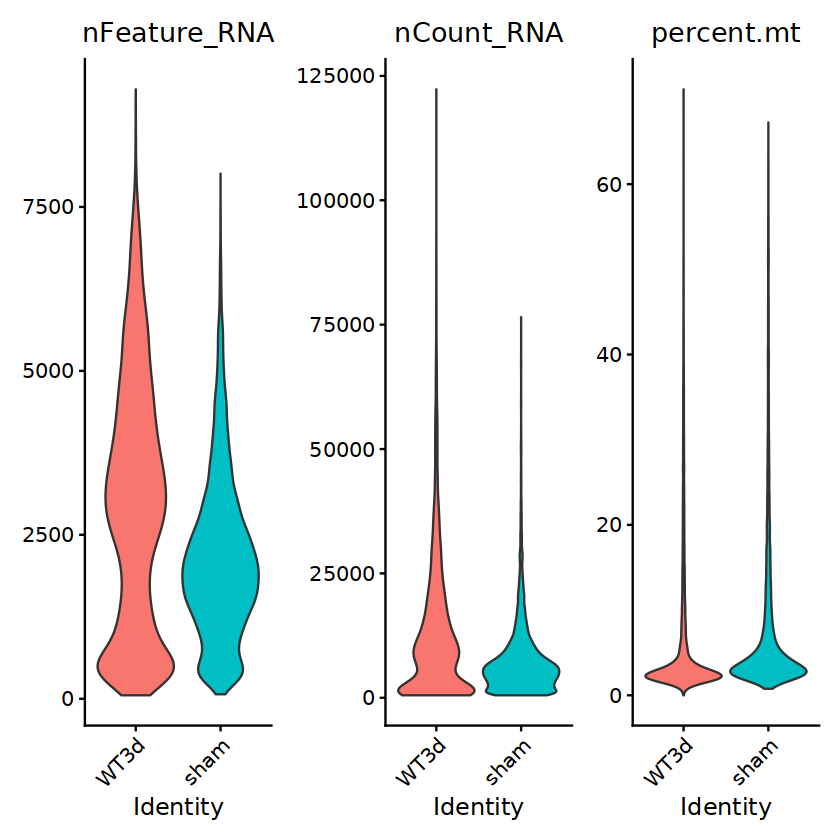

Saving 13 x 6.67 in image


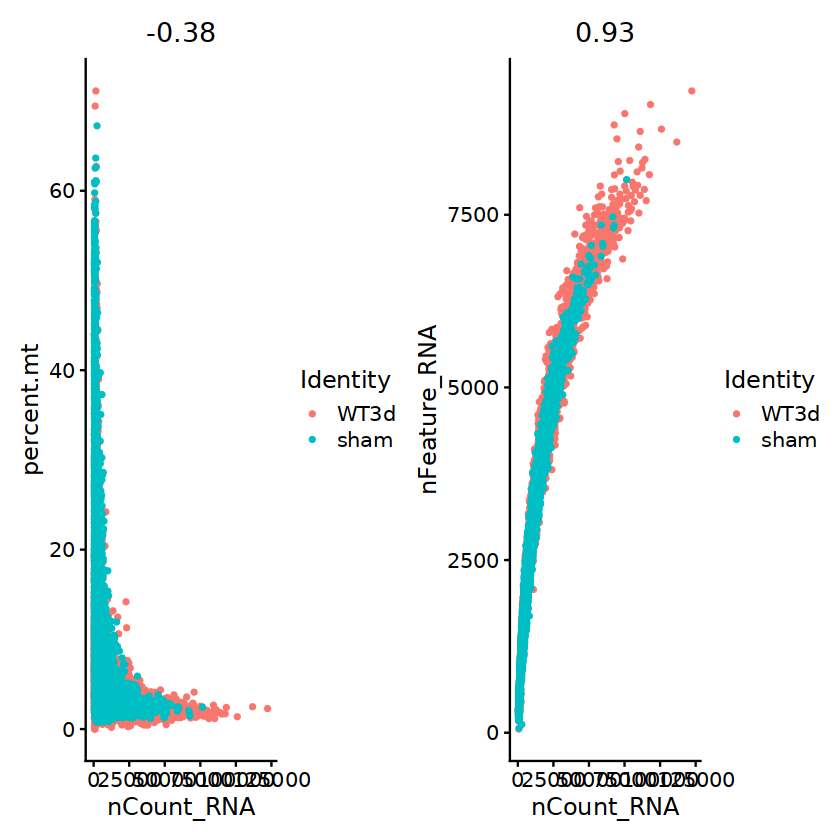

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.1     v dplyr   1.1.2
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.4     v forcats 1.0.0
v purrr   1.0.1     
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'patchwork' was built under R 

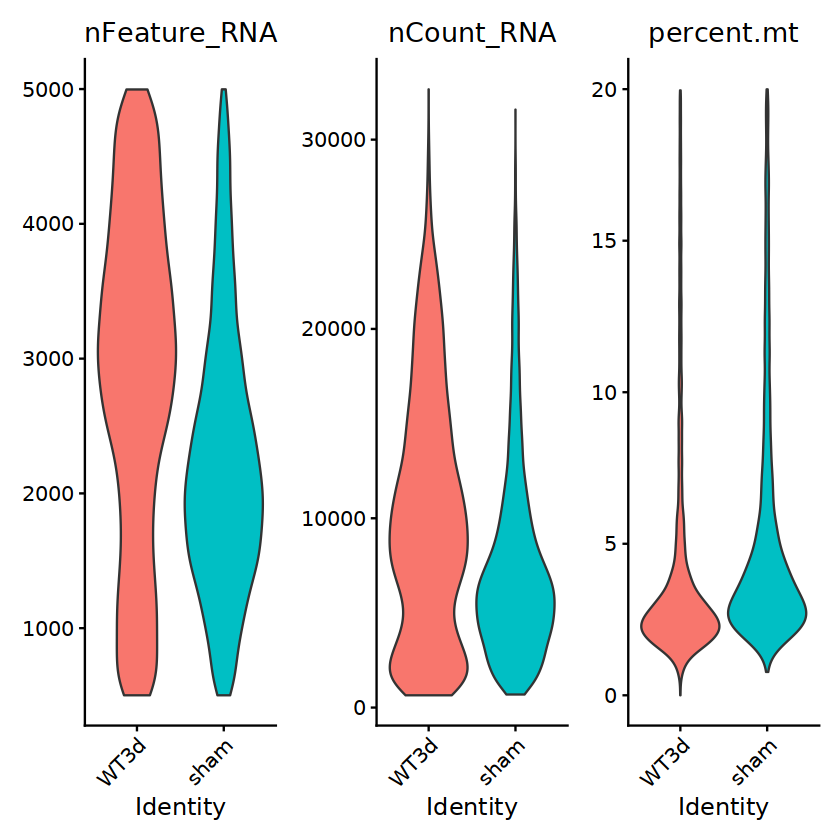

In [6]:






immune.combined = single.ob

immune.combined[["percent.mt"]] <- PercentageFeatureSet(immune.combined,pattern = "^mt-")

VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

library(ggplot2)

ggsave('figure1.pdf',height =  4,width = 6)

Idents(immune.combined) = 'orig.ident'

plot1 <- FeatureScatter(immune.combined, 
                        feature1 = "nCount_RNA", 
                        feature2 = "percent.mt")
plot2 <- FeatureScatter(immune.combined, 
                        feature1 = "nCount_RNA", 
                        feature2 = "nFeature_RNA")
plot1 + plot2

ggsave('scatter.pdf',,width = 13)

immune.combined <-   subset(immune.combined, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.mt < 20)

VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

ggsave('figure1-1.pdf',height =  4,width = 6)

library(DoubletFinder)
library(tidyverse)
library(Seurat)
library(patchwork)

In [7]:
immune.combined <-NormalizeData(immune.combined)
immune.combined <- ScaleData(immune.combined,feature=rownames(immune.combined), verbose = FALSE)
immune.combined <- FindVariableFeatures(object = immune.combined,selection.method = 'vst', nfeatures = 2000)
immune.combined <- RunPCA(immune.combined,  features = VariableFeatures(object = immune.combined) ,verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- RunTSNE(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
13:26:36 UMAP embedding parameters a = 0.9922 b = 1.112

13:26:36 Read 14624 rows and found 20 numeric columns

13:26:36 Using Annoy for neighbor search, n_neighbors = 30

13:26:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:26:37 Writing NN index file to temp file /tmp/RtmpZDyI6c/file3fdea4bea8f63

13:26:37 Searching Annoy index using 1 thread, search_k = 3000

13:26:41 Annoy recall = 100%

13:26:42 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14624
Number of edges: 486149

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8867
Number of communities: 24
Elapsed time: 4 seconds


In [8]:
H9 = immune.combined

In [9]:
paramSweep = function (seu, PCs = 1:20, sct = FALSE, num.cores = 1) 
{
    require(Seurat)
    require(fields)
    require(parallel)
    pK <- c(5e-04, 0.001, 0.005, seq(0.01, 0.3, by = 0.01))
    pN <- seq(0.05, 0.3, by = 0.05)
    min.cells <- round(nrow(seu@meta.data)/(1 - 0.05) - nrow(seu@meta.data))
    pK.test <- round(pK * min.cells)
    pK <- pK[which(pK.test >= 1)]
    orig.commands <- seu@commands
    if (nrow(seu@meta.data) > 10000) {
        real.cells <- rownames(seu@meta.data)[sample(1:nrow(seu@meta.data), 
            10000, replace = FALSE)]
        data <- seu@assays$RNA@counts[, real.cells]
        n.real.cells <- ncol(data)
    }
    if (nrow(seu@meta.data) <= 10000) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts
        n.real.cells <- ncol(data)
    }
    if (num.cores > 1) {
        require(parallel)
        cl <- makeCluster(num.cores)
        output2 <- mclapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct, mc.cores = num.cores)
        stopCluster(cl)
    }
    else {
        output2 <- lapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct)
    }
    sweep.res.list <- list()
    list.ind <- 0
    for (i in 1:length(output2)) {
        for (j in 1:length(output2[[i]])) {
            list.ind <- list.ind + 1
            sweep.res.list[[list.ind]] <- output2[[i]][[j]]
        }
    }
    name.vec <- NULL
    for (j in 1:length(pN)) {
        name.vec <- c(name.vec, paste("pN", pN[j], "pK", pK, 
            sep = "_"))
    }
    names(sweep.res.list) <- name.vec
    return(sweep.res.list)
}

In [10]:
sweep.res.list_kidney <- paramSweep(H9, PCs = 1:20, sct = FALSE)

Loading required package: fields

Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridisLite

Warning message:
"package 'viridisLite' was built under R version 4.2.3"

Try help(fields) to get started.

Loading required package: parallel



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

Warning message:
"package 'KernSmooth' was built under R version 4.2.3"
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Warning message:
"package 'ROCR' was built under R version 4.2.3"


NULL


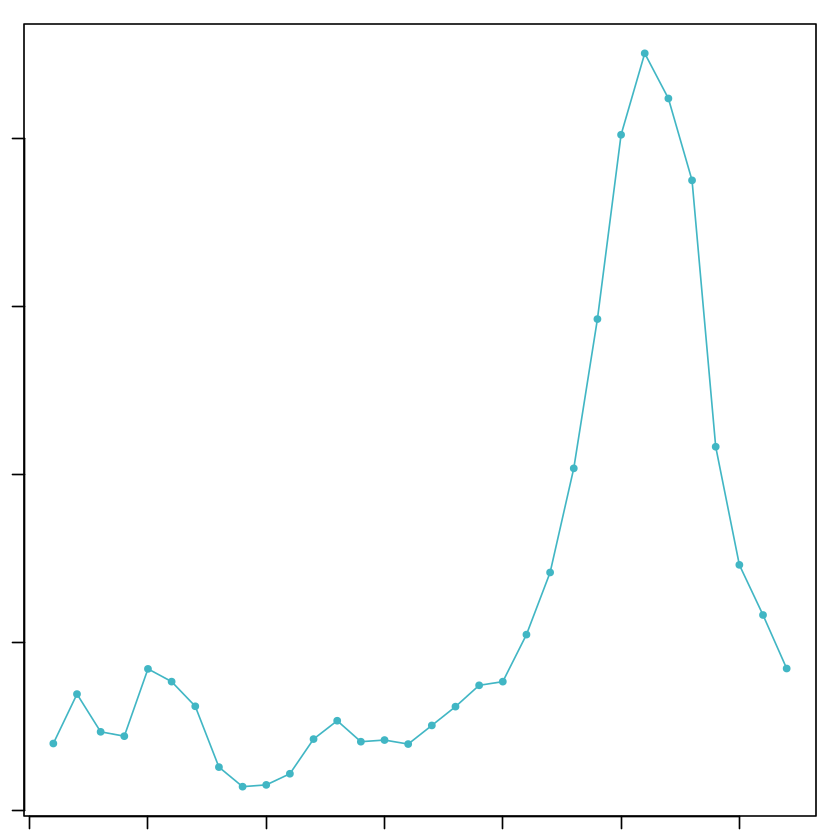

In [11]:
sweep.stats_kidney <- summarizeSweep(sweep.res.list_kidney, GT = FALSE)
bcmvn_kidney <- find.pK(sweep.stats_kidney)

In [12]:
pK_bcmvn <- bcmvn_kidney$pK[which.max(bcmvn_kidney$BCmetric)] %>% as.character() %>% as.numeric()

In [13]:
DoubletRate = ncol(H9)*8*1e-7

In [14]:
DoubletRate

[1] 0.0116992

In [15]:
homotypic.prop <- modelHomotypic(H9$orig.ident)

In [16]:
nExp_poi <- round(DoubletRate*ncol(H9)) 
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

In [17]:
doubletFinder = function (seu, PCs, pN = 0.25, pK, nExp, reuse.pANN = FALSE, 
    sct = FALSE, annotations = NULL) 
{
    require(Seurat)
    require(fields)
    require(KernSmooth)
    if (reuse.pANN != FALSE) {
        pANN.old <- seu@meta.data[, reuse.pANN]
        classifications <- rep("Singlet", length(pANN.old))
        classifications[order(pANN.old, decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        return(seu)
    }
    if (reuse.pANN == FALSE) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts[, real.cells]
        n_real.cells <- length(real.cells)
        n_doublets <- round(n_real.cells/(1 - pN) - n_real.cells)
        print(paste("Creating", n_doublets, "artificial doublets...", 
            sep = " "))
        real.cells1 <- sample(real.cells, n_doublets, replace = TRUE)
        real.cells2 <- sample(real.cells, n_doublets, replace = TRUE)
        doublets <- (data[, real.cells1] + data[, real.cells2])/2
        colnames(doublets) <- paste("X", 1:n_doublets, sep = "")
        data_wdoublets <- cbind(data, doublets)
        if (!is.null(annotations)) {
            stopifnot(typeof(annotations) == "character")
            stopifnot(length(annotations) == length(Cells(seu)))
            stopifnot(!any(is.na(annotations)))
            annotations <- factor(annotations)
            names(annotations) <- Cells(seu)
            doublet_types1 <- annotations[real.cells1]
            doublet_types2 <- annotations[real.cells2]
        }
        orig.commands <- seu@commands
        if (sct == FALSE) {
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Normalizing Seurat object...")
            seu_wdoublets <- NormalizeData(seu_wdoublets, normalization.method = orig.commands$NormalizeData.RNA@params$normalization.method, 
                scale.factor = orig.commands$NormalizeData.RNA@params$scale.factor, 
                margin = orig.commands$NormalizeData.RNA@params$margin)
            print("Finding variable genes...")
            seu_wdoublets <- FindVariableFeatures(seu_wdoublets, 
                selection.method = orig.commands$FindVariableFeatures.RNA$selection.method, 
                loess.span = orig.commands$FindVariableFeatures.RNA$loess.span, 
                clip.max = orig.commands$FindVariableFeatures.RNA$clip.max, 
                mean.function = orig.commands$FindVariableFeatures.RNA$mean.function, 
                dispersion.function = orig.commands$FindVariableFeatures.RNA$dispersion.function, 
                num.bin = orig.commands$FindVariableFeatures.RNA$num.bin, 
                binning.method = orig.commands$FindVariableFeatures.RNA$binning.method, 
                nfeatures = orig.commands$FindVariableFeatures.RNA$nfeatures, 
                mean.cutoff = orig.commands$FindVariableFeatures.RNA$mean.cutoff, 
                dispersion.cutoff = orig.commands$FindVariableFeatures.RNA$dispersion.cutoff)
            print("Scaling data...")
            seu_wdoublets <- ScaleData(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                model.use = orig.commands$ScaleData.RNA$model.use, 
                do.scale = orig.commands$ScaleData.RNA$do.scale, 
                do.center = orig.commands$ScaleData.RNA$do.center, 
                scale.max = orig.commands$ScaleData.RNA$scale.max, 
                block.size = orig.commands$ScaleData.RNA$block.size, 
                min.cells.to.block = orig.commands$ScaleData.RNA$min.cells.to.block)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                npcs = length(PCs), rev.pca = orig.commands$RunPCA.RNA$rev.pca, 
                weight.by.var = orig.commands$RunPCA.RNA$weight.by.var, 
                verbose = FALSE)
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        if (sct == TRUE) {
            require(sctransform)
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Running SCTransform...")
            seu_wdoublets <- SCTransform(seu_wdoublets)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, npcs = length(PCs))
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        print("Calculating PC distance matrix...")
        dist.mat <- fields::rdist(pca.coord)
        print("Computing pANN...")
        pANN <- as.data.frame(matrix(0L, nrow = n_real.cells, 
            ncol = 1))
        if (!is.null(annotations)) {
            neighbor_types <- as.data.frame(matrix(0L, nrow = n_real.cells, 
                ncol = length(levels(doublet_types1))))
        }
        rownames(pANN) <- real.cells
        colnames(pANN) <- "pANN"
        k <- round(nCells * pK)
        for (i in 1:n_real.cells) {
            neighbors <- order(dist.mat[, i])
            neighbors <- neighbors[2:(k + 1)]
            pANN$pANN[i] <- length(which(neighbors > n_real.cells))/k
            if (!is.null(annotations)) {
                for (ct in unique(annotations)) {
                  neighbors_that_are_doublets = neighbors[neighbors > 
                    n_real.cells]
                  if (length(neighbors_that_are_doublets) > 0) {
                    neighbor_types[i, ] <- table(doublet_types1[neighbors_that_are_doublets - 
                      n_real.cells]) + table(doublet_types2[neighbors_that_are_doublets - 
                      n_real.cells])
                    neighbor_types[i, ] <- neighbor_types[i, 
                      ]/sum(neighbor_types[i, ])
                  }
                  else {
                    neighbor_types[i, ] <- NA
                  }
                }
            }
        }
        print("Classifying doublets..")
        classifications <- rep("Singlet", n_real.cells)
        classifications[order(pANN$pANN[1:n_real.cells], decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("pANN", pN, pK, nExp, sep = "_")] <- pANN[rownames(seu@meta.data), 
            1]
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        if (!is.null(annotations)) {
            colnames(neighbor_types) = levels(doublet_types1)
            for (ct in levels(doublet_types1)) {
                seu@meta.data[, paste("DF.doublet.contributors", 
                  pN, pK, nExp, ct, sep = "_")] <- neighbor_types[, 
                  ct]
            }
        }
        return(seu)
    }
}

In [18]:
scRNA <- doubletFinder(H9, PCs = 1:20, pN = 0.25, pK = pK_bcmvn, 
                          nExp = nExp_poi.adj, reuse.pANN = F, sct = F)

[1] "Creating 4875 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


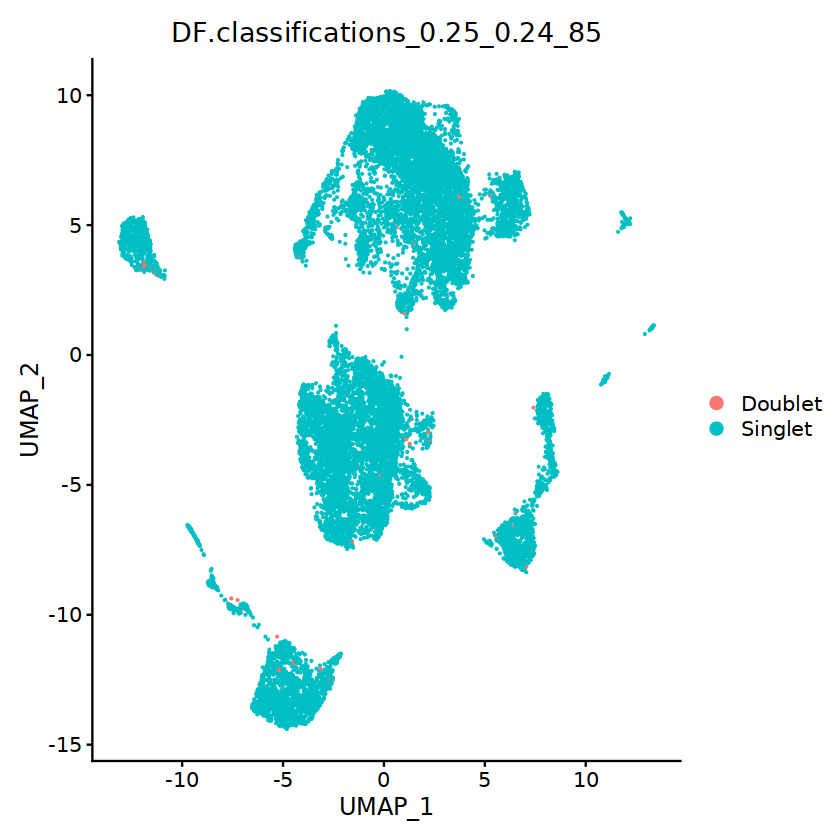

In [21]:
DimPlot(scRNA, reduction = "umap", group.by = "DF.classifications_0.25_0.24_85")

In [22]:
ggsave('figure2.pdf',height =  4,width = 5)

In [25]:
immune.combined = subset(scRNA, subset = DF.classifications_0.25_0.24_85  != 'Doublet')

In [26]:
table(immune.combined$orig.ident)


WT3d sham 
7080 7459 

In [27]:
ifnb.list <- SplitObject(immune.combined, split.by = "orig.ident")

testAB.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)
testAB.integrated <- IntegrateData(anchorset = testAB.anchors, dims = 1:20)

DefaultAssay(testAB.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
testAB.integrated <- ScaleData(testAB.integrated, features = rownames(testAB.integrated))
testAB.integrated <- RunPCA(testAB.integrated, npcs = 50, verbose = FALSE)
testAB.integrated <- FindNeighbors(testAB.integrated, dims = 1:30)
testAB.integrated <- FindClusters(testAB.integrated, resolution = 0.5)
testAB.integrated <- RunUMAP(testAB.integrated, dims = 1:30)
testAB.integrated <- RunTSNE(testAB.integrated, dims = 1:30)

immune.combined = testAB.integrated

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15325 anchors

Filtering anchors

	Retained 4014 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14539
Number of edges: 512887

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9084
Number of communities: 20
Elapsed time: 3 seconds


13:55:51 UMAP embedding parameters a = 0.9922 b = 1.112

13:55:51 Read 14539 rows and found 30 numeric columns

13:55:51 Using Annoy for neighbor search, n_neighbors = 30

13:55:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:55:52 Writing NN index file to temp file /tmp/RtmpZDyI6c/file3fdea1aa9cbb3

13:55:53 Searching Annoy index using 1 thread, search_k = 3000

13:55:56 Annoy recall = 100%

13:55:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:55:59 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

13:55:59 Using 'irlba' for PCA

13:55:59 PCA: 2 components explained 45.93% variance

13:55:59 Scaling init to sdev = 1

13:55:59 Commencing optimization for 200 epochs, with 619954

In [28]:
saveRDS(immune.combined,file = 'before_rename.rds')

In [29]:
library(Seurat)

In [30]:
scRNA = readRDS('./before_rename.rds')

In [53]:
Idents(scRNA) = 'orig.ident'

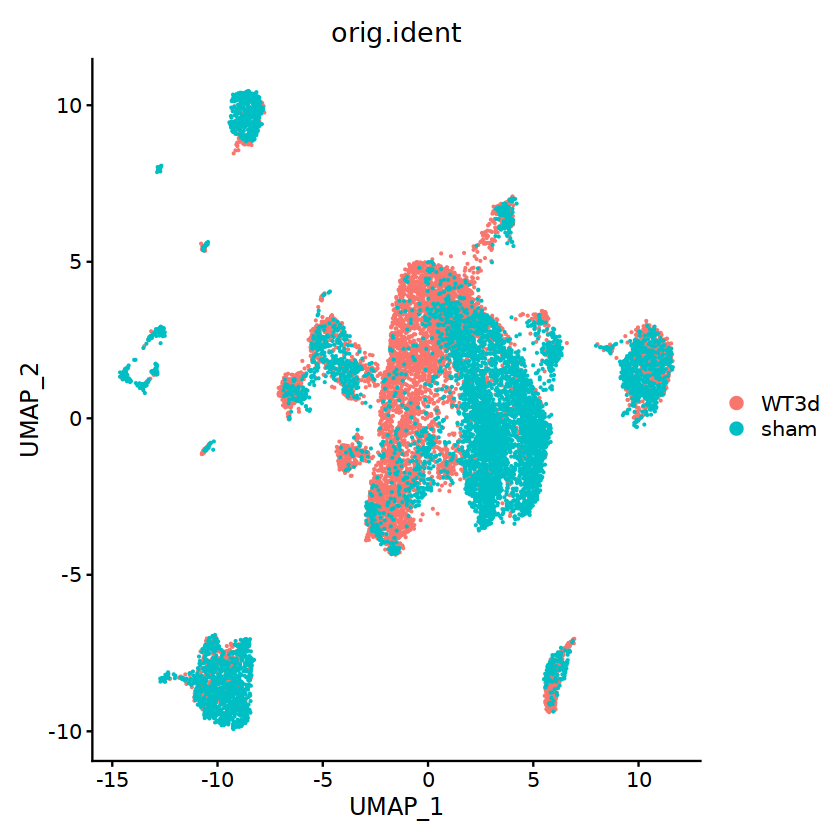

In [31]:
DimPlot(scRNA, reduction = "umap", group.by = "orig.ident")

In [8]:
library(ggplot2)

Warning message:
"package 'ggplot2' was built under R version 4.2.3"


In [9]:
ggsave('figure3.pdf',height =  4,width = 5)

In [11]:
immune.combined = scRNA

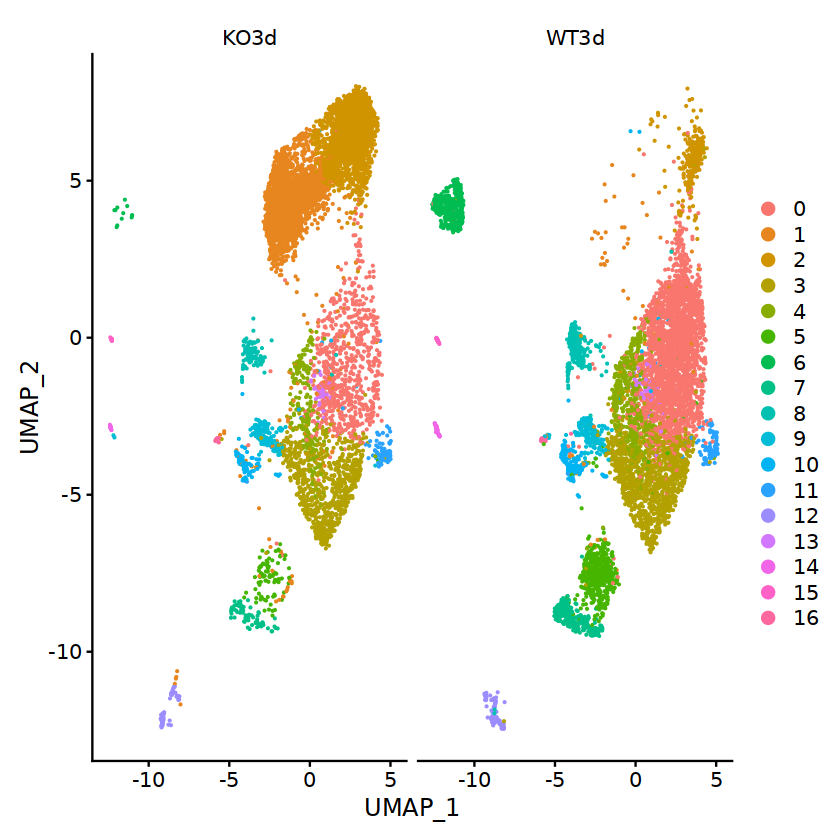

In [12]:
DimPlot(immune.combined, reduction = "umap", split.by  = "orig.ident",ncol = 2)

In [32]:
ggsave('figure4.pdf',height =  8,width = 12)

In [33]:
scRNA = immune.combined

In [34]:
library(Seurat) ##
library(SingleR)
library(ggplot2)
library(reshape2)
mouseImmu  = get(load('/import/DB/SingleR_ref/ref_Mouse_all.RData'))
pbmc_for_SingleR <- GetAssayData(scRNA, slot="data") ##获取标准化矩阵
clusters=scRNA@meta.data$seurat_clusters
pred.mouseImmu <- SingleR(test = pbmc_for_SingleR, ref = mouseImmu, labels = mouseImmu$label.main,
 method = "cluster", clusters = clusters, 
 assay.type.test = "logcounts", assay.type.ref = "logcounts")
celltype = data.frame(ClusterID=rownames(pred.mouseImmu), celltype=pred.mouseImmu$labels, stringsAsFactors = FALSE)

Warning message:
"package 'SingleR' was built under R version 4.2.3"
Loading required package: SummarizedExperiment

Warning message:
"package 'SummarizedExperiment' was built under R version 4.2.2"
Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.2.3"

Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWe

In [35]:
scRNA@meta.data$celltype = "NA"
# 赋值
for(i in 1:nrow(celltype)){
  scRNA@meta.data[which(scRNA@meta.data$seurat_clusters == celltype$ClusterID[i]),'celltype'] <- celltype$celltype[i]}

In [18]:
#scRNA = readRDS('./after_rename.rds')

Warning message in gzfile(file, "rb"):
"cannot open compressed file './after_rename.rds', probable reason 'No such file or directory'"


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [36]:
scRNA

An object of class Seurat 
34285 features across 14539 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

In [37]:
library(Seurat)

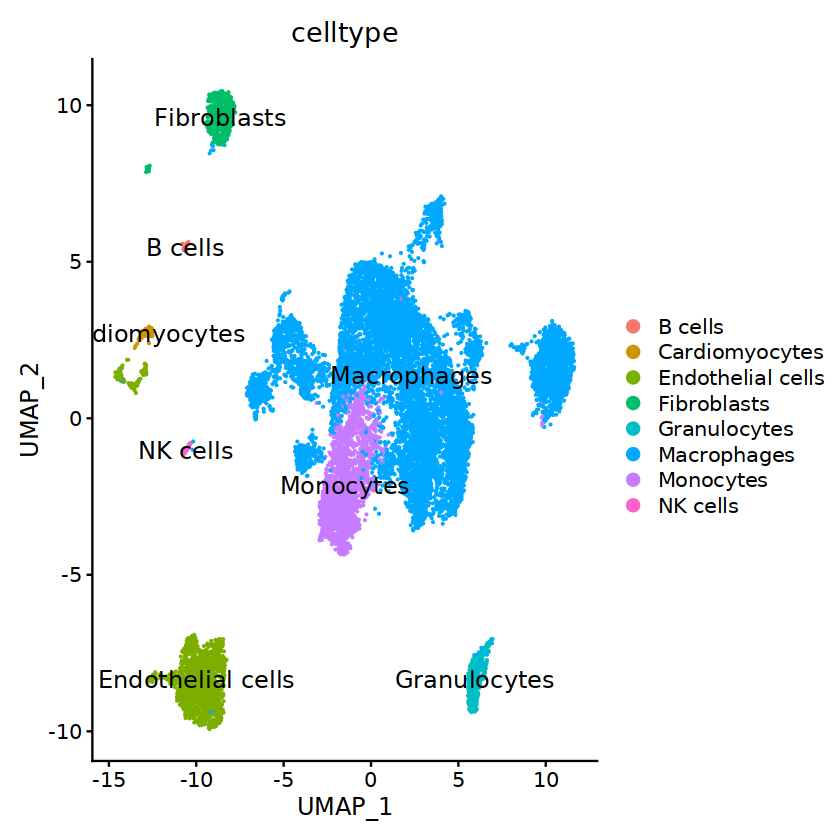

In [38]:
DimPlot(scRNA, group.by="celltype", label=T, label.size=5, reduction='umap')

In [39]:
library(ggplot2)

In [40]:
ggsave('figure5.pdf',height =  8,width = 9)

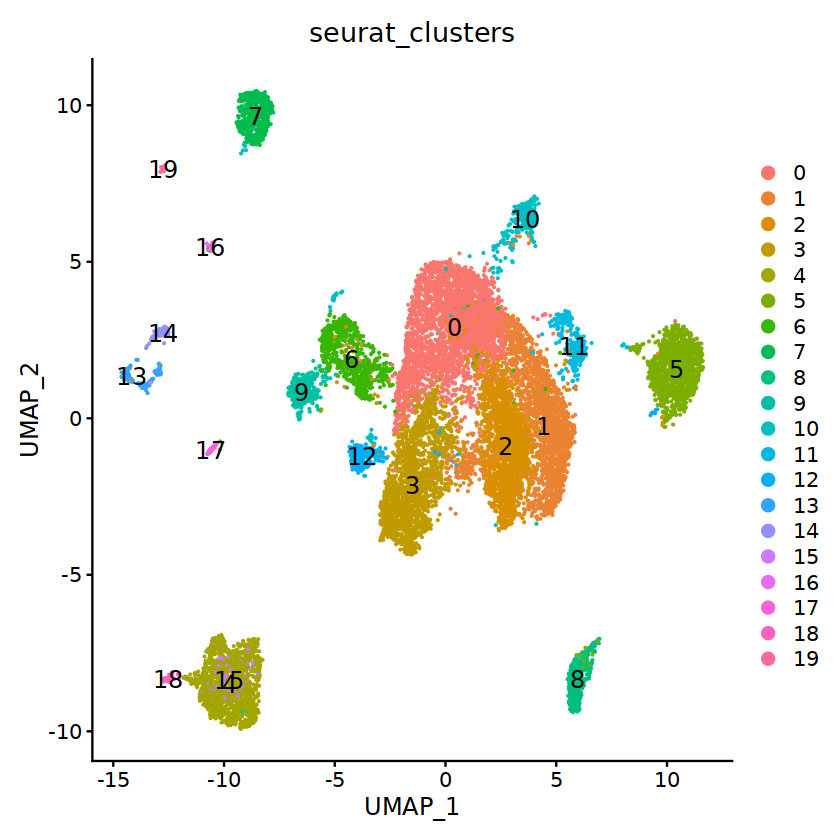

In [41]:
DimPlot(scRNA, group.by="seurat_clusters", label=T, label.size=5, reduction='umap')

In [42]:
ggsave('figure6.pdf',height =  8,width = 9)

In [48]:
table(scRNA$celltype)


          B cells    Cardiomyocytes Endothelial cells       Fibroblasts 
               67                96              1488               512 
     Granulocytes       Macrophages         Monocytes          NK cells 
              435             10093              1783                65 

In [49]:
Idents(scRNA) = 'celltype'

In [50]:
sce = subset(scRNA,idents = c('Macrophages','Monocytes'))

In [52]:
saveRDS(sce,file = 'mac.rds')